# Predicting generated revenues after investing in advertisement   

***Context***

A company aims to invest money in marketing compaign. Three different channels are available : TV, radio and newspapers. We have past investments data and the corresponding generated revenues. The goal is to leverage this data and perform a predictive model which can help to find the optimal investment strategy for the future.   

***Summary***

We start by manipulating and describing data. Pandas, Numpy and Seaborn are used for this purpose. We select some performance metrics (R2 score and RMSE) and then build models using sci-kit learn library. Two different algorithms are used : decision trees and linear regression. To improve predictive performance we have introduced a new feature. Finally we simulate 7 investment scenarios and select the most profitable one.  

# Import libraries 

In [1]:
#author: houcem
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
np.random.seed(0)
sns.set(style="darkgrid", color_codes=True)

# Import data set 

In [2]:
#Import the data set and display the first rows
data = pd.read_csv('/home/houcem/Bureau/Advertising.csv')
#Remove the index column
data = data.drop("Unnamed: 0", axis=1)
print('The data set shape is ', data.shape)

The data set shape is  (200, 4)


In [3]:
data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


The dataset captures sales revenue generated with respect to advertisement spends across multiple channels :  radio, tv and newspaper.

- TV - Spend on TV ads
- Radio - Spend on radio ads
- Newspaper - Spend on newspaper ads
- Sales - Sales revenue generated
- Note: The amounts are in different units

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
radio        200 non-null float64
newspaper    200 non-null float64
sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


# General descriptive insights 
We have 200 instances. Each of them has 3 features and one target variable : sales. 
All parameters are numerical and continous. 


Let's analyse them further 


count    200.000000
mean      14.022500
std        5.217457
min        1.600000
25%       10.375000
50%       12.900000
75%       17.400000
max       27.000000
Name: sales, dtype: float64


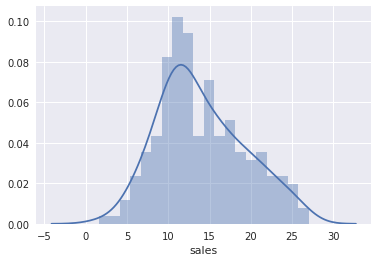

In [5]:
# decribe sales 
print(data.sales.describe())
#sales distribution 
sns.distplot(data.sales,bins=20)
plt.show()

Sales have a skrewed to the left distibution. Now let's look more closely at features : 

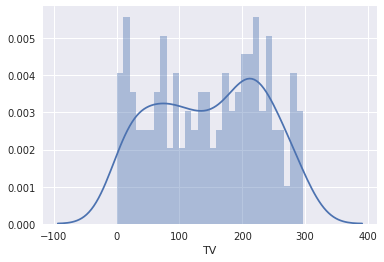

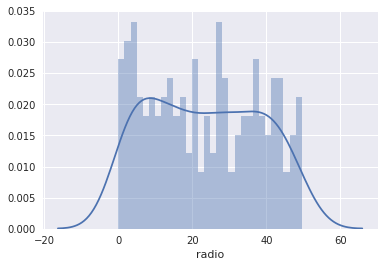

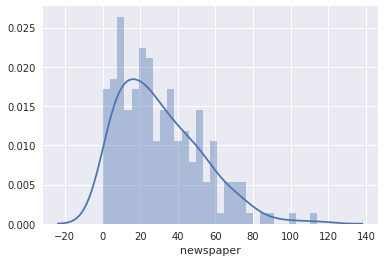

In [157]:
features = ["TV","radio","newspaper"]
for i in features:
    sns.distplot(data[i],bins=30)
    plt.show()

Intuitively we should expect a positive correlation between investment and sales. Let's check this trend for every feature : 

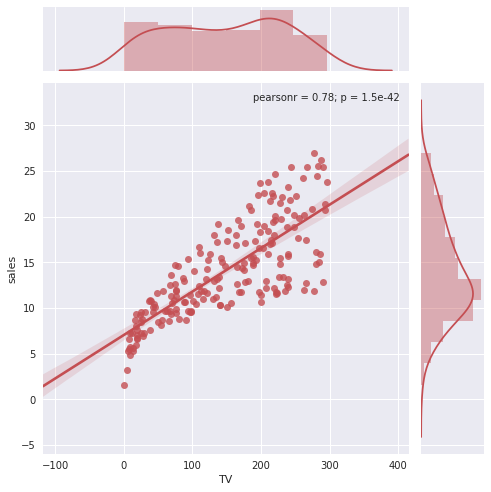

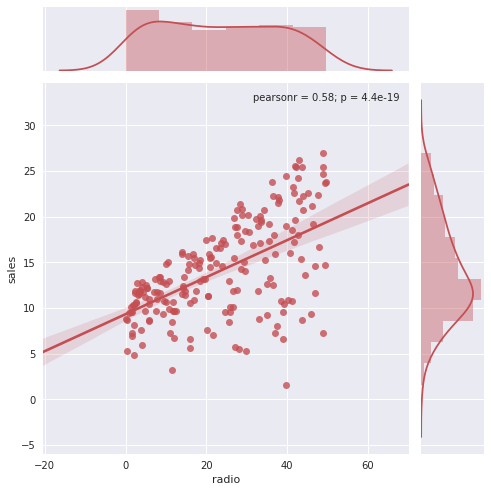

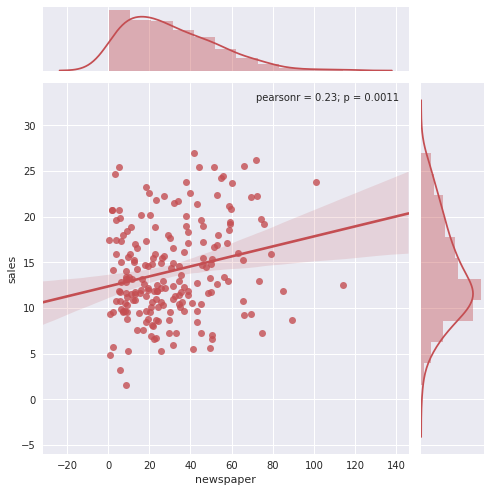

In [158]:
#see the general trend 
plt.figure(figsize=(15, 8))
features = ['TV', 'radio', 'newspaper']
# i: index
for i, col in enumerate(features):
    x = data[col]
    sns.jointplot(col, "sales", data=data, kind="reg",
            color="r", size=7)
    plt.show()

We expected to have a clear correlation pattern between investment and sales.  
This trend seems to be less abvious when it comes to newspapers because Pearson correlation coefficient is low.

# Performance metric 

In machine learning, it is important to select a perfomance metric to help to select between different algorithms and models.  


***R2 score*** : 

- R-squared is a statistical measure of how close the data are to the fitted regression line.

- R-square signifies percentage of variations in the reponse variable that can be explained by the model.
- R-squared = Explained variation / Total variation
- Total variation is variation of response variable around it's mean.
- R-squared value varies between 0 and 100%. 0% signifies that the model explains none of the variability, while 100% signifies that the model explains all the variability of the response. The closer the r-square to 100%, the better is the model.

***Root mean squared error***

- RMSE calculate the difference between the actual value and predicted value of the response variable.
- The square root of the mean/average of the square of all of the error.
- Compared to the similar Mean Absolute Error, RMSE amplifies and severely punishes large errors.
- The lesser the RMSE value, the better is the model.



We choose R2 score as the performance metric for GridSearch optimisation and learning curves. RMSE is also taken into account in model validation and comparison.  


In [3]:
#  choose a performance metric
from sklearn.metrics import r2_score,mean_squared_error

# We choose R2_score as main performance metric 
#For more flexibility, we introduce a function 
def performance_metric(y_true, y_predict):
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)

    # Return the score
    return score

# Train test split 

In [4]:
# train_test_split
from sklearn.cross_validation import train_test_split

y = data["sales"]
X = data.drop("sales", axis = 1)

#Shuffle and split the data into training and testing subsets
X_train_0, X_test_0, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=10)

print(" The number of training examples is ", y.shape[0])
print(" Training data represent {}% of all data".format(100*float(X_train_0.shape[0]) / float(y.shape[0])))
print(" Testing data represent {}% of all data\n".format(100*float(X_test_0.shape[0]) / float(y.shape[0])))


print("First rows of Training data :\n",X_train_0.head())
print("\nFirst rows of Testing data :\n",X_test_0.head())

 The number of training examples is  200
 Training data represent 80.0% of all data
 Testing data represent 20.0% of all data

First rows of Training data :
         TV  radio  newspaper
190   39.5   41.1        5.8
7    120.2   19.6       11.6
26   142.9   29.3       12.6
138   43.0   25.9       20.5
58   210.8   49.6       37.7

First rows of Testing data :
         TV  radio  newspaper
59   210.7   29.5        9.3
5      8.7   48.9       75.0
20   218.4   27.7       53.4
198  283.6   42.0       66.2
52   216.4   41.7       39.6


/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Scaling 

Given that features values are in different units and have different ranges. A best practice is to scale the inputs. Here we use StandardScaler from sklearn. 

Decision trees don't usually require scaling. However, it is useful if you intend to compare performance with other data or other methods.

First, we fit the scaler with training data and then transform training and testing data. 

In [5]:
from sklearn.preprocessing import StandardScaler

def scale(training,testing):
    scaler = StandardScaler()
    scaler.fit(training)
    X_train = pd.DataFrame(scaler.transform(training), columns=training.columns)
    X_test = pd.DataFrame(scaler.transform(testing),columns=testing.columns)
    return X_train,X_test

X_train,X_test = scale(X_train_0,X_test_0)
print("First rows of Training data :\n",X_train.head())
print("\nFirst rows of Testing data :\n",X_test.head())

First rows of Training data :
          TV     radio  newspaper
0 -1.297934  1.310292  -1.129118
1 -0.306299 -0.179168  -0.859089
2 -0.027364  0.492821  -0.812532
3 -1.254927  0.257278  -0.444734
4  0.806986  1.899148   0.356043

First rows of Testing data :
          TV     radio  newspaper
0  0.805757  0.506676  -0.966169
1 -1.676402  1.850654   2.092610
2  0.900374  0.381977   1.086984
3  1.701546  1.372641   1.682911
4  0.875798  1.351858   0.444501


# Algorithm 1 : Decision tree regression 

In [6]:
from sklearn.tree import DecisionTreeRegressor

*** Some useful functions ***

-These Model learning : Calculates the performance of several models with varying sizes of training data.The learning and testing scores for each model are then plotted.

-Model complexity : Calculates the performance of the model as model complexity increases.The learning and testing errors rates are then plotted.

In [7]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
import sklearn.learning_curve as curves

def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()
    
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()
    

/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


/home/houcem/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


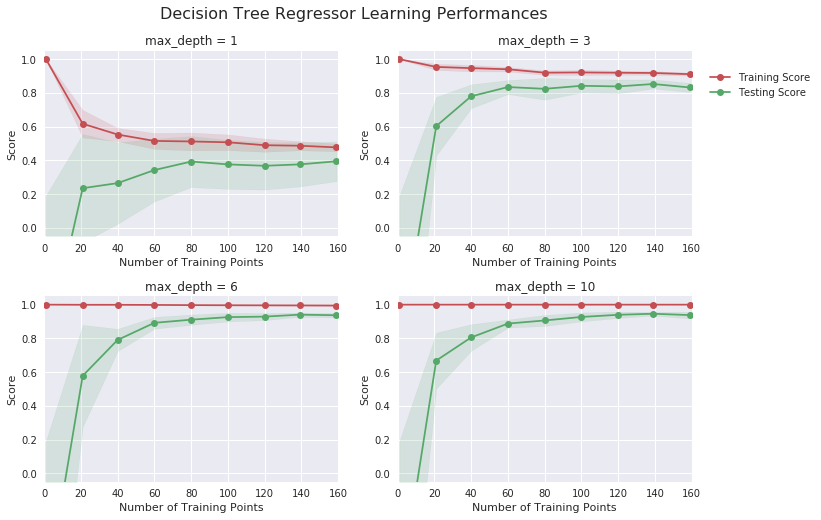

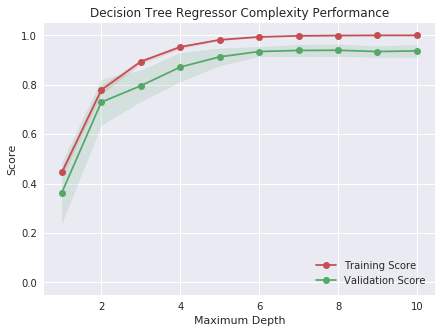

In [11]:
#Learning curves 
ModelLearning(X, y)
ModelComplexity(X_train, y_train)

Drawing learning curves and model complexity curve tells us that a choice of max-depth > 6  is more likely to insure a good trade-off between underfitting and overfitting.

To be sure about this let's conduct a gridSearch and find the optimal hyperparameter for max_depth varying in the range [1,2,3,4,5,6,7,8,9,10,11,12,15,20]

In [8]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """

    # Create cross-validation sets from the training data
    # ShuffleSplit works iteratively compared to KFOLD
    # It saves computation time when your dataset grows
    # X.shape[0] is the total number of elements
    # n_iter is the number of re-shuffling & splitting iterations.
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    # Instantiate
    regressor = DecisionTreeRegressor(random_state=0)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    dt_range = [1,2,3,4,5,6,7,8,9,10,11,12,15,20]
    params = dict(max_depth=dt_range)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    # We initially created performance_metric using R2_score
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    # You would realize we manually created each, including scoring_func using R^2
    grid = GridSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

/home/houcem/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [9]:
# Fit the training data to the model using grid search
best_decision_tree = fit_model(X_train, y_train) # reg is the best decision tree regressor
# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(best_decision_tree.get_params()['max_depth']))
print("The best decision tree model R2 score on training data ", performance_metric(y_train,best_decision_tree.predict(X_train)))
print("The best decision tree model R2 score on testing data ", performance_metric(y_test,best_decision_tree.predict(X_test)))
print("Root Mean Squared Error = RMSE = " ,  np.sqrt( mean_squared_error( y_test, best_decision_tree.predict(X_test) )))


Parameter 'max_depth' is 10 for the optimal model.
The best decision tree model R2 score on training data  0.999992021072
The best decision tree model R2 score on testing data  0.949457419338
Root Mean Squared Error = RMSE =  1.43424631776


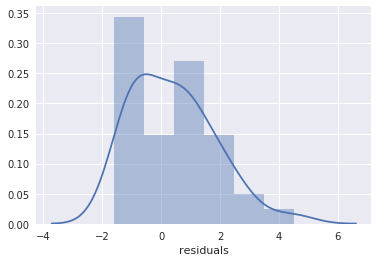

Residuals standard deviation is 1.40 


In [17]:
# check residuals distribution  
test_pred_df = pd.DataFrame( { 'actual': y_test,
                            'predicted': np.round( best_decision_tree.predict(X_test), 2),
                            'residuals': y_test - best_decision_tree.predict(X_test) } )
sns.distplot(test_pred_df.residuals)
plt.show()
print("Residuals standard deviation is {:,.2f} ".format(test_pred_df.residuals.std()))

This decision tree model seems to have very good performances. Now let's try another algorithm and pick the best one of them.

# Algorithm 2 :  Linear regression

In [18]:
#linear regression 
from sklearn.linear_model import LinearRegression

#fitting the training data 
linreg = LinearRegression()
linreg.fit( X_train, y_train )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
#display model data and weights
print("intercept term  is ", linreg.intercept_)
list( zip( ["TV", "Radio", "Newspaper"], list( linreg.coef_ ) ) )

intercept term  is  13.83125


[('TV', 3.5622476686956532),
 ('Radio', 2.7921588290268948),
 ('Newspaper', -0.047872587132496314)]

So, the linear equation found looks like

Sales = 13.83 + 3.56 TV + 2,79 Radio -0.04 * Newspaper

Newspaper's weight is very small if compared to TV and Radio. This can explain the low correlation coefficient between sales and newspapers. 

In [20]:
#prediction 
y_pred = linreg.predict( X_test )
    
print("Model score on training data is ", performance_metric(y_train,linreg.predict( X_train) ))
print("Model score on testing data is ", performance_metric( y_test, y_pred ))
print("Root Mean Squared Error = RMSE =" ,  np.sqrt( mean_squared_error( y_test, linreg.predict(X_test) )))

Model score on training data is  0.92090875535
Model score on testing data is  0.835367232467
Root Mean Squared Error = RMSE = 2.58852984463


In [21]:
# finding the best linear regressor 
linreg = LinearRegression()
#hyperparameters range 
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(linreg, parameters, cv=None)
grid.fit(X_train, y_train)
best_linear_regressor = grid.best_estimator_
best_linear_regressor

print("Best linear regressor R2 score on training data is ", performance_metric(y_train,best_linear_regressor.predict( X_train) ))
print("Best linear regressor R2 score on testing data is ", performance_metric( y_test, best_linear_regressor.predict( X_test) ))
print("Root Mean Squared Error = RMSE =" ,  np.sqrt( mean_squared_error( y_test, best_linear_regressor.predict(X_test) )))


Best linear regressor R2 score on training data is  0.92090875535
Best linear regressor R2 score on testing data is  0.835367232467
Root Mean Squared Error = RMSE = 2.58852984463


Analysing residuals 

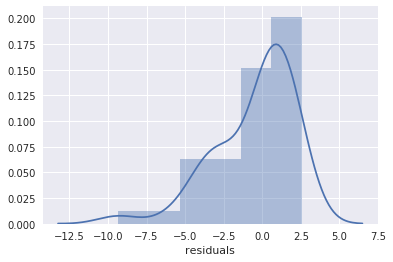

Residuals standard deviation is 2.57 


In [24]:
test_pred_df = pd.DataFrame( { 'actual': y_test,
                            'predicted': np.round( best_linear_regressor.predict(X_test), 2),
                            'residuals': y_test - best_linear_regressor.predict(X_test) } )
# check residuals distribution  
sns.distplot(test_pred_df.residuals)
plt.show()
print("Residuals standard deviation is {:,.2f} ".format(test_pred_df.residuals.std()))

Linear regression seems to have lower predictive performances and larger range of residuals. 
Decision tree residuals distribution is closer to zero (more flat around zero) and has a smaller range 

***Compare algorithms***

| Algorithm | Training R2_score | Testing R2_score | RMSE | Residuals std
| ----| ------------ | -------- | -----------|
| Decision tree |    0.9999    | 0.9494   | 1.4342 | 1.40 
| Linear regression |    0.9209    | 0.8353   | 2.5885 | 2.57  


We select Decision tree model because it has better scores, lower RMSE and less dispersed residuals.  


# Adding a new feature 


An very important insight we saw when we built linear regression is the importance of TV and Radio weights if compared to newspapers. 
It can be intresting to try to create an interaction variable for TV and Radio spendings. Maybe spending 10 000 on television ads and 10 000 on radio ads will result more sales than spending 20 000 to either TV or radio individually. This is known as a synergy effect. 

Let's add a new feature by multiplying Radio and TV spendings. 

In [25]:
#creating a new feature
#synergy effect or interaction effect

X_train_0['tv_radio'] = X_train_0.TV * X_train_0.radio
X_test_0['tv_radio'] = X_test_0.TV * X_test_0.radio

X_train_0.head() 

/home/houcem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/houcem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,TV,radio,newspaper,tv_radio
190,39.5,41.1,5.8,1623.45
7,120.2,19.6,11.6,2355.92
26,142.9,29.3,12.6,4186.97
138,43.0,25.9,20.5,1113.70
58,210.8,49.6,37.7,10455.68


Scaling 

In [26]:
X_train,X_test = scale(X_train_0,X_test_0)
X_train.head()

,TV,radio,newspaper,tv_radio
0,-1.297934,1.310292,-1.129118,-0.530757
1,-0.306299,-0.179168,-0.859089,-0.298174
2,-0.027364,0.492821,-0.812532,0.283245
3,-1.254927,0.257278,-0.444734,-0.692620
4,0.806986,1.899148,0.356043,2.273767


## Fitting with a Decision tree 

In [27]:
# Fit the training data to the model using grid search
best_decision_tree = fit_model(X_train, y_train) # reg is the best decision tree regressor
# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(best_decision_tree.get_params()['max_depth']))

print("Model R2 score on training data ", performance_metric(y_train,best_decision_tree.predict(X_train)))
print("Model R2 score on testing data ", performance_metric(y_test,best_decision_tree.predict(X_test)))
print("Root Mean Squared Error = RMSE =" ,  np.sqrt( mean_squared_error( y_test, best_decision_tree.predict(X_test) )))

Parameter 'max_depth' is 6 for the optimal model.
Model R2 score on training data  0.997365976562
Model R2 score on testing data  0.985004485638
Root Mean Squared Error = RMSE = 0.781224258835


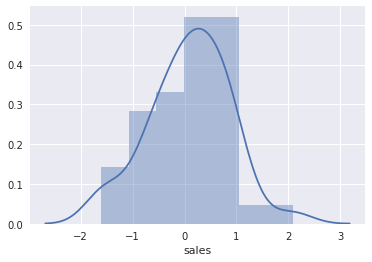

Residuals standard deviation is 0.79 


In [30]:
#compute residuals 
residuals = y_test - best_decision_tree.predict(X_test)
sns.distplot( residuals )
plt.show()
print("Residuals standard deviation is {:,.2f} ".format(residuals.std()))

## Fitting with a Linear regression 

In [31]:
# finding the best linear regressor 
linreg = LinearRegression()
#hyperparameters range 
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(linreg, parameters, cv=None)
grid.fit(X_train, y_train)
best_linear_regressor = grid.best_estimator_
best_linear_regressor


print("Best linear regressor score on training data is ", performance_metric(y_train,best_linear_regressor.predict( X_train) ))
print("Best linear regressor on testing data is ", performance_metric( y_test, best_linear_regressor.predict( X_test) ))
print("Root Mean Squared Error = RMSE =" ,  np.sqrt( mean_squared_error( y_test, best_linear_regressor.predict(X_test) )))

Best linear regressor score on training data is  0.972390810289
Best linear regressor on testing data is  0.951271890603
Root Mean Squared Error = RMSE = 1.40826640117


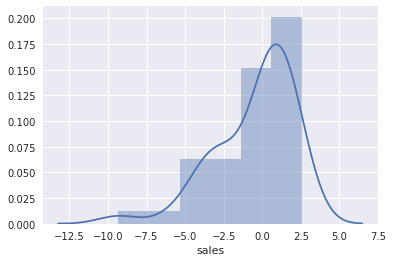

Residuals standard deviation is 2.57 


In [32]:
#compute residuals 
residuals = y_test - y_pred
sns.distplot( residuals )
plt.show()
print("Residuals standard deviation is {:,.2f} ".format(residuals.std()))

The range of residuals with linear regression are larger than with decision tree. 


***Compare algorithms after adding a new feature ***

| Algorithm | Training R2_score | Testing R2_score | RMSE | Residuals standard deviation|
| ----| ------------ | -------- | -----------|
| Decision tree |    0.9973    | 0.9850   | 0.7812 | 0.79 
| Linear regression |    0.9723    | 0.9512   | 1.4082 | 2.57

Again we see that decision tree is better than linear regression. So we choose decision tree for the next steps 

# Select decision tree model and k-cross validate it

In [33]:
from sklearn.model_selection import cross_val_score

# add new feature to all data 
X['tv_radio'] = X.TV * X.radio


# Scoring is R2
cv_scores = cross_val_score(best_decision_tree, X, y, scoring = 'r2', cv = 10 ) # stratified 10 folds
print( "Average r2 score: ", np.round( np.mean( cv_scores ), 2 ) )
print( "Standard deviation in r2 score: ", np.round( np.std( cv_scores ), 2) )

# Scoring is MSE
cv_scores = cross_val_score(best_decision_tree, X, y, scoring = make_scorer(mean_squared_error), cv = 10 ) # stratified 10 folds
print( "\nAverage RMSE score: ", np.round( np.mean( np.sqrt(cv_scores) ), 2 ) )
print( "Standard deviation in RMSE score: ", np.round( np.std( np.sqrt(cv_scores) ), 2) )

Average r2 score:  0.98
Standard deviation in r2 score:  0.01

Average RMSE score:  0.64
Standard deviation in RMSE score:  0.15


In [35]:
best_decision_tree.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

## How should we invest 200 millions 

Let's assume we have 200 millions. We want to invest them in advertisement. We have defined 7 different investment scenarios :

| Scenario | TV | Radio | Newspaper |
| -------- | ----- | ------ | ------ |
|1|20|20|160|
|2|20|160|20|
|3|160|20|20|
|4|80|80|40|
|5|40|80|80|
|6|80|40|80|
|7|66,66|66,66|66,66|

In [36]:
#We have 200 millions and we simulate 7 different scenarios 
              # TV|Radio|Newspaper 
unseen_data = [[0.1, 0.1, 0.8],
               [0.1, 0.8, 0.1],
               [0.8, 0.1, 0.1],
               [0.4, 0.4, 0.2],
               [0.2, 0.4, 0.4],
               [0.4, 0.2, 0.4],
               [1/3, 1/3, 1/3]]


#preprocess unseen_data
a = np.array(unseen_data)
a = a*200    # mulitply strategy by amout of total investment : 200 millions
b = a[:,0] * a[:,1]  # create the new feature TV*Radio 
b = b.reshape(-1,1)
unseen_data = np.concatenate((a, b), axis=1)

print("Preprocessed data:\n", unseen_data)

Preprocessed data:
 [[   20.            20.           160.           400.        ]
 [   20.           160.            20.          3200.        ]
 [  160.            20.            20.          3200.        ]
 [   80.            80.            40.          6400.        ]
 [   40.            80.            80.          3200.        ]
 [   80.            40.            80.          3200.        ]
 [   66.66666667    66.66666667    66.66666667  4444.44444444]]


In [91]:
# Show predictions
predicted_sales = []
for i, sales in enumerate(best_decision_tree.predict(unseen_data)):
    print("Predicted sales for strategy {} is : {:,.2f}".format(i+1, sales))
    predicted_sales.append(sales)

Predicted sales for strategy 1 is : 7.60
Predicted sales for strategy 2 is : 9.33
Predicted sales for strategy 3 is : 14.50
Predicted sales for strategy 4 is : 18.95
Predicted sales for strategy 5 is : 14.50
Predicted sales for strategy 6 is : 14.50
Predicted sales for strategy 7 is : 15.95


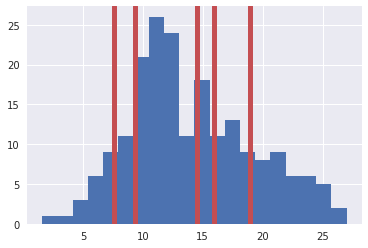

The difference between best and worst investment is  11.35
Best investment generates 149.34% more sales than worst investment 


In [110]:
#show the predicted sales in sales distribution 
plt.figure()
plt.hist(y, bins = 20)
for sales in best_decision_tree.predict(unseen_data):
    plt.axvline(sales, lw = 5, c = 'r')
plt.show() 

print("The difference between best and worst investment is "
      , np.max(predicted_sales) - np.min(predicted_sales))
print("Best investment generates {:,.2f}% more sales than worst investment ".format( 100*(np.max(predicted_sales) - np.min(predicted_sales))/np.min(predicted_sales)))

- For the same amount of invested money we can see very different predicted sales. It goes from 7 to 19
- The difference between scenarios is quite important according to our predictions. 

When we predict, we usually want to make sure that prediction for a specific scenario doesn't change much with the data it's trained on.
So we add this function PredictTrials 

In [111]:
#useful function for sensitivity 
def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted sales
    sales = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # Fit the data
        reg = fitter(X_train, y_train)
        
        # Make a prediction
        pred = reg.predict([data])
        sales.append(float(pred))
        
        # Result
        print("Trial {}: {:,.2f}".format(k+1, float(pred)))

    # Display sales range
    print ("\nRange in sales: {:,.2f}".format(max(sales) - min(sales)))

Let's test it on every scenario and see the range of predicted values 

In [112]:
for i in range(0,len(unseen_data),1):
    unseen = unseen_data[i, :]
    print("\nPredictions for investment ", i+1)
    print("-------Investment : [TV | Radio | Newspaper] : ", unseen_data[i,0:3])
    PredictTrials(X, y, fit_model, unseen)


Predictions for investment  1
-------Investment : [TV | Radio | Newspaper] :  [  20.   20.  160.]
Trial 1: 7.00
Trial 2: 7.00
Trial 3: 7.20
Trial 4: 7.60
Trial 5: 7.17
Trial 6: 7.00
Trial 7: 7.00
Trial 8: 7.60
Trial 9: 7.00
Trial 10: 7.00

Range in sales: 0.60

Predictions for investment  2
-------Investment : [TV | Radio | Newspaper] :  [  20.  160.   20.]
Trial 1: 9.30
Trial 2: 8.80
Trial 3: 8.80
Trial 4: 14.70
Trial 5: 14.65
Trial 6: 10.80
Trial 7: 11.60
Trial 8: 9.50
Trial 9: 14.70
Trial 10: 10.40

Range in sales: 5.90

Predictions for investment  3
-------Investment : [TV | Radio | Newspaper] :  [ 160.   20.   20.]
Trial 1: 14.53
Trial 2: 14.20
Trial 3: 14.50
Trial 4: 14.40
Trial 5: 14.65
Trial 6: 14.50
Trial 7: 14.30
Trial 8: 14.65
Trial 9: 14.50
Trial 10: 14.40

Range in sales: 0.45

Predictions for investment  4
-------Investment : [TV | Radio | Newspaper] :  [ 80.  80.  40.]
Trial 1: 19.00
Trial 2: 19.00
Trial 3: 19.00
Trial 4: 19.00
Trial 5: 19.20
Trial 6: 19.20
Trial 7: 19.

# Best strategy 
Between the 7 simulated strategies, we recommend number 4. It represents an investment of 40% and 40% in TV and radio and only 20% in newspapers. More detailed scenarios can also be studied. 

# How to improve results 

Some questions we should keep asking are : 
- How relevant today is the collected data ? What about other channels such as social media, billboards, posters and catalogues ? 
- Can we bring more relevant features to the problem to predict sales ? such as product design, customers satisfaction ? 
- Are the features present in the data sufficient to predict sales ?  
- Is the model robust enough to make consistent predictions ?
- Improve model by boosting or bagging

# Conclusion 

Building machine learning models can help businesses to leverage data and see more clearly the patterns. In this application, we created value by recommending the most profitable advertisement strategy. 